## First look -- transit and ramps

In [1]:
%matplotlib nbagg

In [1]:
import os
import sys
import numpy as np
from jwst import datamodels
import glob
import matplotlib.pyplot as plt

sys.path.insert(0, '/home/ym20900/ExoTiC-JEDI/')
import exotic_jedi as jedi

In [2]:
# Setting some rc params

plt.rcParams['figure.figsize'] = [6.0, 3.0]           # Dimensions
plt.rcParams['figure.dpi'] = 300                       # Resolution
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['image.aspect'] = 7                      # Aspect ratio
plt.rcParams['lines.linewidth'] = 1

cmap = plt.cm.magma
cmap.set_bad('k',1.)

from matplotlib import cycler
plt.rcParams['image.cmap'] = 'magma'                   # Colormap.
plt.rcParams['image.interpolation'] = None
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['axes.prop_cycle'] = cycler(color=['dodgerblue','lawngreen','tomato','darkorchid','gold','lightgray'])

/tmp/ipykernel_2520613/3838393533.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("magma").copy()
  cmap.set_bad('k',1.)
/tmp/ipykernel_2520613/3838393533.py:14: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['image.interpolation'] = None


This notebook takes a brief look at the raw jwst data to:
- Make an unclean light curve and sanity check the existence of a transit signal.
- Visualise the ramps before passing the data to stage 1.

### Data loader

First we load the chunks into a single array with shape (chunk, integration, group, row, column). Combining many chunks will result in a massive array in memory, so may just want to look at a few in turn here.

In [3]:
# Directory containing dataset.
raw_data_dir = '/PATH/TO/YOUR/DATA/'

# Build list of all datachunks.
raw_data_chunks = sorted(glob.glob(raw_data_dir+'*nrs2_uncal.fits'))

In [4]:
# Load science data.
sci_data = []
for rdc in raw_data_chunks:
    print('Loading data chunk {}'.format(rdc))
    sci_data.append(datamodels.RampModel(rdc).data)
    print(datamodels.RampModel(rdc).data.shape)
sci_data = np.concatenate(sci_data) #replaces .array with .concatenate to allow for differing segment lengths
print('Loaded all data chunks with total array size {} GB and shape {}.'.format(
    round(sys.getsizeof(sci_data) / 1e9, 4), sci_data.shape))

Loading data chunk /data/praxis2/shared_area/jwst/toi_836_02/g395h/2512_10/stage0/jw02512010001_04102_00001-seg001_nrs2_uncal.fits
(1524, 3, 32, 2048)
Loading data chunk /data/praxis2/shared_area/jwst/toi_836_02/g395h/2512_10/stage0/jw02512010001_04102_00001-seg002_nrs2_uncal.fits
(1524, 3, 32, 2048)
Loading data chunk /data/praxis2/shared_area/jwst/toi_836_02/g395h/2512_10/stage0/jw02512010001_04102_00001-seg003_nrs2_uncal.fits
(1524, 3, 32, 2048)
Loading data chunk /data/praxis2/shared_area/jwst/toi_836_02/g395h/2512_10/stage0/jw02512010001_04102_00001-seg004_nrs2_uncal.fits
(687, 3, 32, 2048)
Loaded all data chunks with total array size 4.1358 GB and shape (5259, 3, 32, 2048).


### Transit

Let's make a transit by summing all the counts in the final groups of each integration. 

In [ ]:
number_of_groups = 2

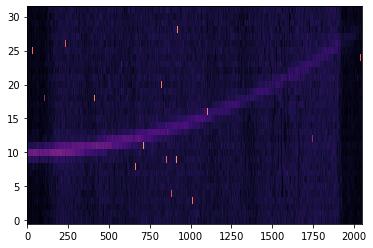

In [5]:
plt.imshow(sci_data[100, number_of_groups, :, :], aspect='auto', interpolation='none')
plt.show()

In [6]:
upper_ap, lower_ap, trace_pos = np.loadtxt('NRS2_aperture.txt', unpack=True)

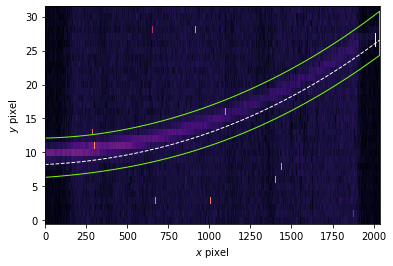

In [7]:
plt.imshow(sci_data[100, number_of_groups, :, 5:-5], aspect='auto')
plt.plot(np.arange(0,len(trace_pos)),trace_pos+1,ls='--',color='w')
plt.xlabel("$x$ pixel")
plt.ylabel("$y$ pixel")

plt.fill_between(np.arange(0,len(upper_ap)), upper_ap+1, lower_ap+3, facecolor = 'None',edgecolor='lawngreen')
plt.show()

Running intrapixel extraction on 5259 spectra
No flat fielding is being performed at this time
No 1/f noise correction is being performed


100%|██████████████████████████████████████████████████████████████████████████████| 5259/5259 [03:06<00:00, 28.27it/s]


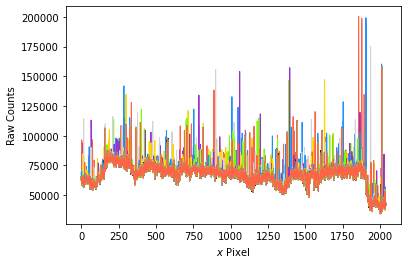

In [8]:
all_spectra, _, _, _ = jedi.get_stellar_spectra(sci_data[:, number_of_groups, :, 5:-5], upper_ap+1, lower_ap+3, \
                                                          flat=None, f_mask=None, \
                                                          extract_method="intrapixel",  \
                                                          shift=False, plot=True, set_to_edge = False)

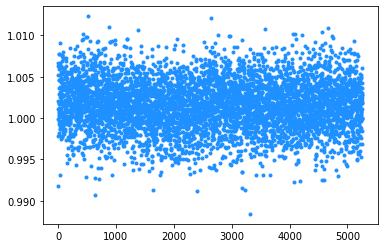

In [9]:
lc = np.sum(all_spectra, axis=1)/np.sum(all_spectra[-1])
fake_time = np.arange(np.shape(all_spectra)[0])

plt.figure()
plt.plot(fake_time[:], lc[:], ls='none',marker='.')
plt.show()

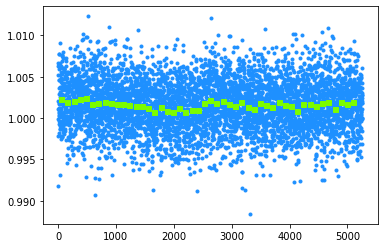

In [11]:
bin_time, bin_flux = jedi.binning(np.arange(0,len(fake_time), len(fake_time)/49), fake_time, lc)

plt.figure()
plt.plot(fake_time[:], lc[:], ls='none',marker='.')
plt.plot(bin_time, bin_flux, ls='none', marker='s', markersize=5)
plt.show()

Do we see a transit signal? Does it occur when we expected it to?

### Ramps

Let's inspect some of the ramps. Maybe try a background pixel, a pixel on the spectral trace, a reference pixel, and the sum of all pixels.

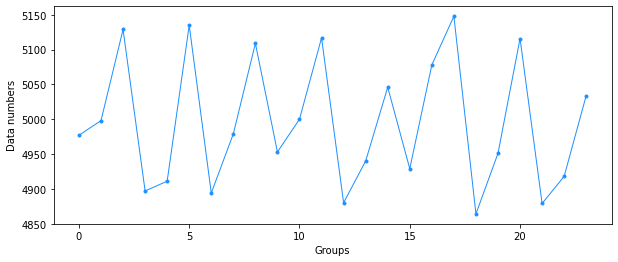

In [12]:
pixel_row = 500 # Pick a random pixel to expect its ramps
pixel_col = 11

integration_start = 300 # idk what this is doing rn, we'll see later when everything breaks I'm sure
integration_end = 308

# chunk_start = 0
# chunk_end = 1

# some_ramps = sci_data[chunk_start: chunk_end, integration_start: intergation_end, :, pixel_row, pixel_col].ravel()
some_ramps = sci_data[integration_start: integration_end, :, pixel_col, pixel_row].ravel()


fig, ax1 = plt.subplots(1, 1, figsize=(10, 4))
ax1.plot(some_ramps,marker='.')
# for i in range(integration_start, integration_end):
#     ax1.plot(sci_data[i, :, pixel_col, pixel_row])
ax1.set_xlabel('Groups')
ax1.set_ylabel('Data numbers')
plt.show()